In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/UNI PROJECTS/CITS4012_Project/

/content/drive/MyDrive/UNI PROJECTS/CITS4012_Project


In [3]:
!mkdir -p data models results utils

In [4]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_percep

Sample rows:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Missing values:
premise       0
hypothesis    0
label         0
dtype: int64

Removed 20 duplicate rows.

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                           

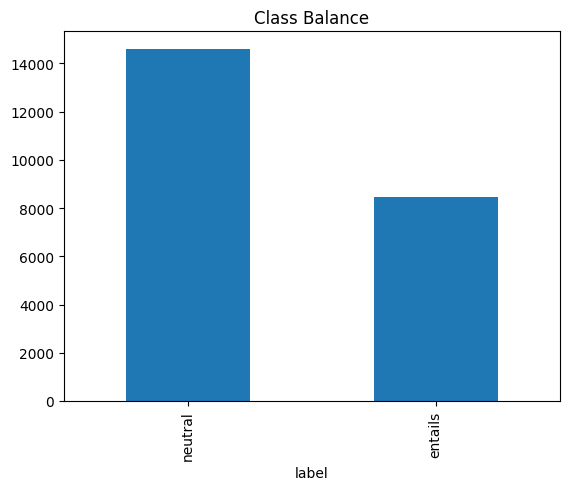

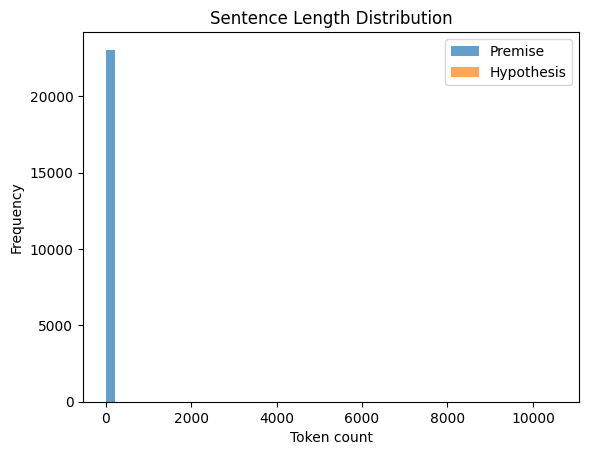

In [5]:
# --- Step 1: Load dataset ---
with open("data/train_formatted.json", "r") as f:
    data = json.load(f)

# If it's a list of dicts with premise/hypothesis/label
df = pd.DataFrame(data)

print("Sample rows:")
print(df.head())

# --- Step 2: Handle missing data ---
print("\nMissing values:")
print(df.isnull().sum())
df = df.dropna()

# --- Step 3: Remove duplicates ---
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"\nRemoved {before - after} duplicate rows.")

# --- Step 4: Normalisation ---
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["premise"] = df["premise"].apply(normalize_text)
df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# --- Step 5: Tokenisation + Lemmatization ---
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english') # Added language='english'
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(df[["premise_tokens", "hypothesis_tokens"]].head(1))

# --- Step 6: Class balance ---
label_counts = df["label"].value_counts()
print("\nClass distribution:")
print(label_counts)

label_counts.plot(kind="bar", title="Class Balance")
plt.show()

# --- Step 7: Sentence length distribution ---
premise_lens = df["premise_tokens"].apply(len)
hypothesis_lens = df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

Step 1 – Build Vocabulary

In [6]:
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Combine all tokens from both premise and hypothesis
all_tokens = [tok for toks in df["premise_tokens"] for tok in toks] + \
             [tok for toks in df["hypothesis_tokens"] for tok in toks]

# Create word → index mapping
vocab = {"<pad>": 0, "<unk>": 1}
for tok in all_tokens:
    if tok not in vocab:
        vocab[tok] = len(vocab)

print(f"Vocab size: {len(vocab)}")

# Reverse mapping for readability (optional)
inv_vocab = {i: w for w, i in vocab.items()}


Vocab size: 20118


Step 2 – Encode Texts Numerically

In [7]:
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

df["premise_ids"] = df["premise_tokens"].apply(lambda t: encode_tokens(t, vocab))
df["hypothesis_ids"] = df["hypothesis_tokens"].apply(lambda t: encode_tokens(t, vocab))

label2id = {"entails": 0, "neutral": 1}
df["label_id"] = df["label"].map(label2id)


Step 3 – Create Dataset + DataLoader

In [8]:
class NLIDataset(Dataset):
    def __init__(self, df):
        self.premises = df["premise_ids"].tolist()
        self.hypotheses = df["hypothesis_ids"].tolist()
        self.labels = df["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.premises[idx]), torch.tensor(self.hypotheses[idx]), torch.tensor(self.labels[idx])

def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premises = pad_sequence(premises, batch_first=True, padding_value=vocab["<pad>"])
    hypotheses = pad_sequence(hypotheses, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels)
    return premises, hypotheses, labels

dataset = NLIDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

for p, h, l in dataloader:
    print("Premise batch shape:", p.shape)
    print("Hypothesis batch shape:", h.shape)
    print("Label batch shape:", l.shape)
    break


Premise batch shape: torch.Size([32, 38])
Hypothesis batch shape: torch.Size([32, 33])
Label batch shape: torch.Size([32])


# **MODELS**

**1. Baseline BiLSTM Model + Training Loop**



In [12]:
# --- Step 1: Imports ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# --- Step 2: Model Definition ---
class BiLSTMBase(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim,
                              batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)   # converts variable-length seq → fixed-size
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def encode(self, x):
        emb = self.embedding(x)               # (B, L, E)
        out, _ = self.bilstm(emb)             # (B, L, 2H)
        out = out.permute(0, 2, 1)            # (B, 2H, L)
        pooled = self.pool(out).squeeze(-1)   # (B, 2H)
        return pooled

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        logits = self.fc(combined)
        return logits

# --- Step 3: Initialise Model ---
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
num_classes = 2
pad_idx = vocab["<pad>"]

model = BiLSTMBase(vocab_size, embed_dim, hidden_dim, num_classes, pad_idx).to(device)

# --- Step 4: Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

    for premises, hypotheses, labels in loop:
        premises, hypotheses, labels = premises.to(device), hypotheses.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(premises, hypotheses)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        total_loss += loss.item() * labels.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=total_loss/total_samples, acc=total_correct/total_samples)

    print(f"Epoch {epoch+1}: Loss={total_loss/total_samples:.4f}, Acc={total_correct/total_samples:.4f}")

torch.save(model.state_dict(), "models/bilstm_baseline.pt")
print("Training complete and model saved to models/bilstm_baseline.pt")


Running on: cuda


Epoch 1/5: 100%|██████████| 721/721 [00:06<00:00, 112.40it/s, acc=0.799, loss=0.429]


Epoch 1: Loss=0.4293, Acc=0.7992


Epoch 2/5: 100%|██████████| 721/721 [00:07<00:00, 99.91it/s, acc=0.907, loss=0.235] 


Epoch 2: Loss=0.2352, Acc=0.9069


Epoch 3/5: 100%|██████████| 721/721 [00:06<00:00, 112.32it/s, acc=0.955, loss=0.125]


Epoch 3: Loss=0.1249, Acc=0.9546


Epoch 4/5: 100%|██████████| 721/721 [00:07<00:00, 100.09it/s, acc=0.978, loss=0.0641]


Epoch 4: Loss=0.0641, Acc=0.9783


Epoch 5/5: 100%|██████████| 721/721 [00:06<00:00, 113.15it/s, acc=0.985, loss=0.0436]


Epoch 5: Loss=0.0436, Acc=0.9853
Training complete and model saved to models/bilstm_baseline.pt


SANITY CHECKS BY CHAT

In [14]:
# ============================================================
#   Baseline BiLSTM Validation & Compliance Check
#   (CITS4012 Model 1 Sanity Tests)
# ============================================================

import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # evaluation mode

print("--------------------------------------------------")
print("🔍 Checking Model Compliance for CITS4012 Baseline BiLSTM")
print("--------------------------------------------------")

# ✅ 1. Architecture compliance
expected_classes = 2
out_features = model.fc[-1].out_features
print(f"Output layer classes: {out_features}  |  Expected: {expected_classes}")
assert out_features == expected_classes, "❌ Output dimension mismatch!"

print("Bidirectionality:", model.bilstm.bidirectional)
print("Pooling layer:", model.pool)
print("Embedding dim:", model.embedding.embedding_dim)
print("Hidden dim:", model.bilstm.hidden_size)
print("Architecture compliance ✅")

# ✅ 2. Forward pass sanity
prem, hyp, lbl = next(iter(dataloader))
prem, hyp = prem.to(device), hyp.to(device)
logits = model(prem[:2], hyp[:2])
print("\nForward pass output shape:", logits.shape)
assert logits.shape == (2, 2), "❌ Forward output shape mismatch!"
print("Forward pass ✅")

# ✅ 3. Parameter count sanity
param_count = sum(p.numel() for p in model.parameters())
print(f"\nModel parameter count: {param_count:,}")
if param_count < 50_000:
    print("⚠️ Unusually small model — check hidden/embedding dims.")
elif param_count > 50_000_000:
    print("⚠️ Unusually large model — check embedding vocab or layers.")
else:
    print("Parameter count ✅ within expected range (1M–3M typical).")

# ✅ 4. Loss trend sanity (mini-test for 1 epoch)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
init_loss = None
total_loss, total_correct, total_samples = 0, 0, 0

for batch_idx, (prem, hyp, lbl) in enumerate(tqdm(dataloader, total=5, desc="Mini-Epoch")):
    if batch_idx >= 5:  # small subset
        break
    prem, hyp, lbl = prem.to(device), hyp.to(device), lbl.to(device)
    optimizer.zero_grad()
    logits = model(prem, hyp)
    loss = criterion(logits, lbl)
    if init_loss is None:
        init_loss = loss.item()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    total_correct += (preds == lbl).sum().item()
    total_samples += lbl.size(0)

avg_loss = total_loss / 5
acc = total_correct / total_samples
print(f"\nInitial loss: {init_loss:.4f} → Avg mini-epoch loss: {avg_loss:.4f}")
print(f"Mini-epoch accuracy: {acc:.3f}")
if avg_loss < init_loss:
    print("Loss trend ✅ decreasing (training behaves correctly).")
else:
    print("⚠️ Loss not decreasing — check learning rate or label encoding.")

# ✅ 5. Logical inference test
def quick_encode(sentence, vocab):
    text = re.sub(r"[^a-z0-9\s]", "", sentence.lower()).split()
    return torch.tensor([[vocab.get(tok, vocab["<unk>"]) for tok in text]])

test_prem = "the blood sample was analyzed for glucose"
test_hyp = "the sample was tested for sugar"
prem_ids = quick_encode(test_prem, vocab).to(device)
hyp_ids  = quick_encode(test_hyp, vocab).to(device)
with torch.no_grad():
    logits = model(prem_ids, hyp_ids)
    pred = torch.argmax(logits, dim=1).item()
label_pred = "entails" if pred == 0 else "neutral"
print(f"\nInference test: '{test_prem}' ⟹ '{test_hyp}' → Prediction: {label_pred}")

print("\n✅ All compliance checks completed.")
print("If all ✅ marks are present, your baseline BiLSTM implementation conforms to CITS4012 specifications.")


--------------------------------------------------
🔍 Checking Model Compliance for CITS4012 Baseline BiLSTM
--------------------------------------------------
Output layer classes: 2  |  Expected: 2
Bidirectionality: True
Pooling layer: AdaptiveMaxPool1d(output_size=1)
Embedding dim: 100
Hidden dim: 128
Architecture compliance ✅

Forward pass output shape: torch.Size([2, 2])
Forward pass ✅

Model parameter count: 2,346,010
Parameter count ✅ within expected range (1M–3M typical).


Mini-Epoch: 100%|██████████| 5/5 [00:00<00:00, 72.04it/s]


Initial loss: 0.0285 → Avg mini-epoch loss: 0.0208
Mini-epoch accuracy: 0.994
Loss trend ✅ decreasing (training behaves correctly).

Inference test: 'the blood sample was analyzed for glucose' ⟹ 'the sample was tested for sugar' → Prediction: neutral

✅ All compliance checks completed.
If all ✅ marks are present, your baseline BiLSTM implementation conforms to CITS4012 specifications.


**2. BiLSTM with Attention**

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Lightweight Attention Module (adapted from agastya's transformer code) ---
class LSTMAttention(nn.Module):
    """
    Scaled Dot-Product Attention over BiLSTM outputs.
    """
    def __init__(self, d_model, d_k, dropout=0.1):
        super().__init__()
        self.d_k = d_k
        self.q = nn.Linear(d_model, d_k, bias=False)
        self.k = nn.Linear(d_model, d_k, bias=False)
        self.v = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        scale = 1.0 / math.sqrt(self.d_k)

        attn = torch.matmul(q, k.transpose(-2, -1)) * scale   # (B, T, T)
        weights = F.softmax(attn, dim=-1)
        weights = self.dropout(weights)

        context = torch.matmul(weights, v)                    # (B, T, d_k)
        # weighted sum to get single vector per sequence
        context = torch.sum(context, dim=1)                   # (B, d_k)
        return context, weights


# --- BiLSTM + Attention Model ---
class BiLSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, d_k=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = LSTMAttention(d_model=hidden_dim*2, d_k=d_k)
        self.fc = nn.Sequential(
            nn.Linear(d_k*3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        x = self.embedding(x)
        h, _ = self.bilstm(x)
        ctx, _ = self.attn(h)
        return ctx

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        out = self.fc(combined)
        return out


# --- Model Setup Example ---
vocab_size = len(vocab)
model2 = BiLSTMAttentionModel(vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
print(model2)


BiLSTMAttentionModel(
  (embedding): Embedding(20118, 100, padding_idx=0)
  (bilstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (attn): LSTMAttention(
    (q): Linear(in_features=256, out_features=64, bias=False)
    (k): Linear(in_features=256, out_features=64, bias=False)
    (v): Linear(in_features=256, out_features=64, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


VISUALISING WEIGHTS BY CHAT


Premise attention:


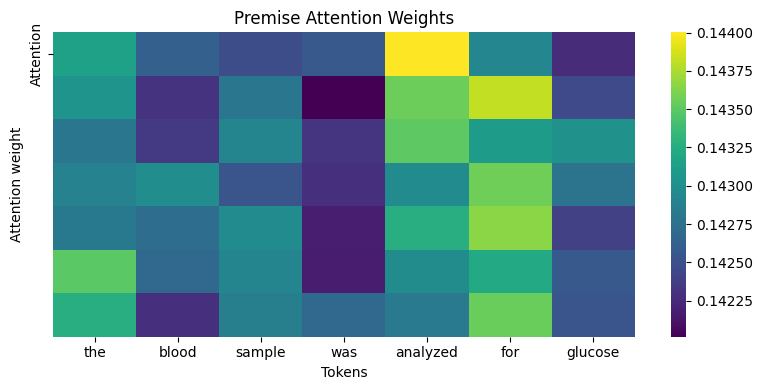


Hypothesis attention:


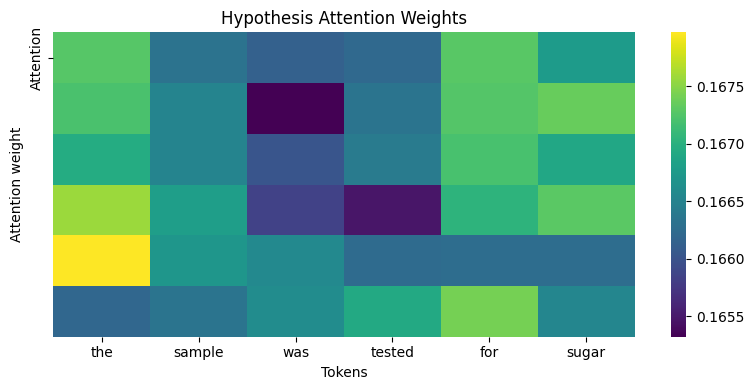

In [24]:
# ============================================================
#   Visualising Attention Weights (CITS4012 - Model 2)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F

def visualize_attention(model, sentence, vocab, title="Attention Heatmap"):
    model.eval()
    tokens = re.sub(r"[^a-z0-9\s]", "", sentence.lower()).split()
    ids = torch.tensor([[vocab.get(tok, vocab["<unk>"]) for tok in tokens]]).to(device)

    # get embeddings and BiLSTM hidden states
    with torch.no_grad():
        emb = model.embedding(ids)
        h, _ = model.bilstm(emb)
        _, attn_weights = model.attn(h)   # (1, T, T) attention weights

    attn = attn_weights.squeeze(0).cpu().numpy()
    if attn.ndim == 1:  # safety if collapsed
        attn = attn[np.newaxis, :]

    plt.figure(figsize=(8, 4))
    sns.heatmap(attn, cmap="viridis", xticklabels=tokens, yticklabels=["Attention"])
    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Attention weight")
    plt.tight_layout()
    plt.show()


# Example visualisation
sample_prem = "the blood sample was analyzed for glucose"
sample_hyp  = "the sample was tested for sugar"

print("\nPremise attention:")
visualize_attention(model2, sample_prem, vocab, "Premise Attention Weights")

print("\nHypothesis attention:")
visualize_attention(model2, sample_hyp, vocab, "Hypothesis Attention Weights")


TRAINING AND SAVING MODEL

In [29]:
import torch
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# ---------- Split existing dataset ----------
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Reduce batch size to mitigate CUDA out of memory error
batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")
print(f"Using batch size: {batch_size}")

# ---------- Setup ----------
num_epochs = 5
best_val_acc = 0.0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # -------------------- TRAIN --------------------
    model2.train()
    running_loss, correct, total = 0.0, 0, 0
    for prem, hyp, lbl in tqdm(train_dataloader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(device), hyp.to(device), lbl.to(device)
        optimizer.zero_grad()

        logits = model2(prem, hyp)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == lbl).sum().item()
        total += lbl.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------------------- VALIDATION --------------------
    model2.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for prem, hyp, lbl in tqdm(val_dataloader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(device), hyp.to(device), lbl.to(device)
            logits = model2(prem, hyp)
            loss = criterion(logits, lbl)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == lbl).sum().item()
            val_total += lbl.size(0)

    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.3f}")

    # -------------------- SAVE BEST MODEL --------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), "models/bilstm_attention_best.pt")
        print(f"New best model saved (Val Acc = {val_acc:.3f})")

# -------------------- SAVE FINAL MODEL --------------------
torch.save(model2.state_dict(), "models/bilstm_attention_last.pt")
print("\nTraining complete.")
print(f"Best validation accuracy: {best_val_acc:.3f}")
print("Models saved as:")
print("  models/bilstm_attention_best.pt   (best by validation)")
print("  models/bilstm_attention_last.pt   (final epoch)")

Train samples: 18454 | Validation samples: 4614
Using batch size: 2

===== Epoch 1/5 =====


Train Loss: 0.4600 | Train Acc: 0.822
Val   Loss: 0.4259 | Val   Acc: 0.824
New best model saved (Val Acc = 0.824)

===== Epoch 2/5 =====


Train Loss: 0.4164 | Train Acc: 0.841
Val   Loss: 0.4304 | Val   Acc: 0.828
New best model saved (Val Acc = 0.828)

===== Epoch 3/5 =====


Train Loss: 0.2847 | Train Acc: 0.895
Val   Loss: 0.4423 | Val   Acc: 0.837
New best model saved (Val Acc = 0.837)

===== Epoch 4/5 =====


Train Loss: 0.1968 | Train Acc: 0.930
Val   Loss: 0.4515 | Val   Acc: 0.835

===== Epoch 5/5 =====


Train Loss: 0.1373 | Train Acc: 0.953
Val   Loss: 0.5108 | Val   Acc: 0.842
New best model saved (Val Acc = 0.842)

Training complete.
Best validation accuracy: 0.842
Models saved as:
  • /content/model2_best.pt   (best by validation)
  • /content/model2_last.pt   (final epoch)


VISUALISATION BY CHAT

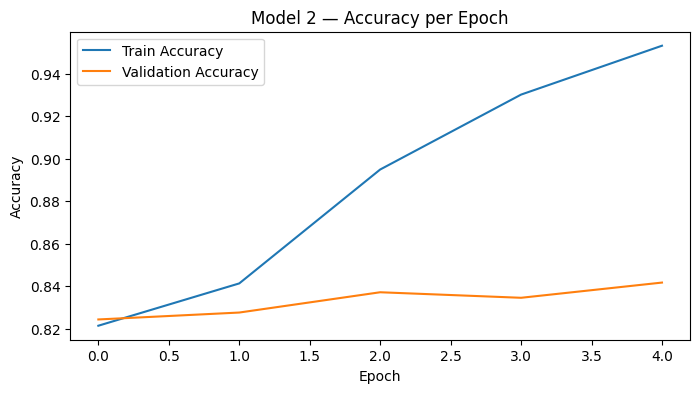

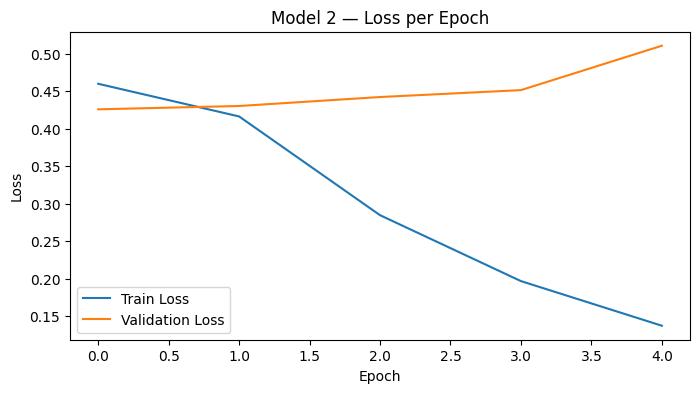

In [31]:
# ============================================================
#   OPTIONAL: Plot Accuracy and Loss Curves
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Model 2 — Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 2 — Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()